# 🏋️ Model Training - Negative Sampled

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import gc
import time
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import torch
from torch import nn
import wandb
from pprint import pprint
import warnings
from transformers import AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/media/ishfar/New Volume/Studies/Projects/Kaggle-Automated-Essay-Scoring/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir("../../")
warnings.filterwarnings("ignore")
load_dotenv()

True

Importing user defined packages

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.model.epoch_functions import train_epoch, valid_epoch
from lib.model.utils import get_score, get_model_optimizer_and_scheduler
from lib.utils.utils import seed_everything
from lib.data import read_data_loader_from_disk
from lib.criterion.metrics import log_metrics
from lib.model.inference import ensemble_inference

In [4]:
pprint(config)

namespace(apex=True,
          batch_scheduler=True,
          batch_size_train=32,
          batch_size_valid=32,
          betas=[0.9, 0.999],
          data_version=6,
          debug=False,
          decoder_lr=2e-05,
          encoder_lr=2e-05,
          epochs=2,
          eps=1e-06,
          gradient_accumulation_steps=1,
          gradient_checkpointing=True,
          max_grad_norm=1000,
          max_length=512,
          min_lr=1e-06,
          model='microsoft/deberta-v3-xsmall',
          n_folds=5,
          negative_sample=True,
          negative_sample_partitions=3,
          num_classes=6,
          num_cycles=0.5,
          num_warmup_steps=0,
          num_workers=6,
          positive_classes=[0, 5],
          negative_classes=[1, 2, 3, 4],
          print_freq=6,
          random_seed=20,
          scheduler='cosine',
          stride=192,
          tokenizer_version=2,
          train=True,
          train_folds=[0, 1, 2, 3, 4, 5, 6, 7],
          weight_decay=0

In [5]:
seed_everything()

In [6]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


### Setting Up WandB

In [7]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
model_name = config.model.split("/")[-1]
WANDB_NAME = f"{model_name}-{config.max_length}-D{config.data_version}-T{config.tokenizer_version}"

In [8]:
wandb.login(key=os.environ.get('WANDB_API_KEY'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
    config=config,
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## 📖 Definitions

### 🌎 Global Variables

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The competition data has a class imbalance problem. Which is why I assign higher weights to classes having lower samples.

In [10]:
# class_weights = torch.tensor([1.0, 0.25, 0.25, 0.5, 1.0, 2.0]).to(device)
class_weights = torch.tensor([1.0] * 6).to(device)

In [11]:
tokenizer = AutoTokenizer.from_pretrained(Paths.TOKENIZER_PATH)
vocabulary = tokenizer.get_vocab()
total_tokens = len(vocabulary)
print("Total number of tokens in the tokenizer:", total_tokens)
print(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of tokens in the tokenizer: 128003
DebertaV2TokenizerFast(name_or_path='output/microsoft/deberta-v3-xsmall/tokenizer_v2', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized

### 🛠️ Functions

In [12]:
def train_loop(fold, group, valid_labels):
    print(f"========== Fold: {fold} Group: {group} training ==========")

    # ======== DATA LOADER ==========
    train_loader, valid_loader = read_data_loader_from_disk(fold, group)

    # ======== MODEL ==========
    model, optimizer, scheduler = get_model_optimizer_and_scheduler(
        train_loader, device
    )

    # ======= LOSS ==========
    # criterion = RMSELoss(reduction="mean") # nn.SmoothL1Loss(reduction='mean')
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    softmax = nn.Softmax(dim=1)

    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.epochs):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(
            fold,
            train_loader,
            model,
            criterion,
            optimizer,
            epoch,
            scheduler,
            device,
        )

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(
            fold, valid_loader, model, criterion, device
        )
        predictions = prediction_dict["predictions"]
        _, predictions = torch.max(softmax(torch.tensor(predictions)), dim=1)

        # ======= SCORING ==========
        score = get_score(valid_labels, predictions)

        wandb.log(
            {
                f"eval/eval_epoch_f{fold}_g{group}": epoch + 1,
                f"eval/eval_loss_f{fold}_g{group}": avg_val_loss,
                f"eval/qwk_score_f{fold}_g{group}": score,
            }
        )

        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1} - "
            + f"avg_train_loss: {avg_loss:.4f} "
            + f"avg_val_loss: {avg_val_loss:.4f} "
            + f"time: {elapsed:.0f}s "
            + f"Score: {score:.4f}"
        )

        if score > best_score:
            best_score = score
            print(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict()},
                Paths.MODEL_OUTPUT_PATH
                + f"/{config.model.replace('/', '_')}_fold_{fold}_group_{group}.pth",
            )

    del model, optimizer, scheduler, criterion, softmax
    torch.cuda.empty_cache()
    gc.collect()

In [13]:
def evaluate_group(fold, valid_fold, valid_labels, model_paths):
    predictions = ensemble_inference(
        valid_fold,
        tokenizer,
        model_paths,
        device,
        overall=False,
    )
    score = get_score(valid_labels, predictions)

    wandb.log(
        {
            f"eval/eval_epoch_f{fold}": config.epochs,
            f"eval/qwk_score_f{fold}": score,
        }
    )
    return predictions

In [14]:
def train_all_groups(fold):
    valid_fold = pd.read_csv(os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.csv"))
    valid_labels = valid_fold["score"].values
    model_paths = {
        os.path.join(
            Paths.MODEL_OUTPUT_PATH,
            f"{config.model.replace('/', '_')}_fold_{fold}_group_{group}.pth",
        ): 1
        for group in range(config.negative_sample_partitions)
    }

    for group in range(config.negative_sample_partitions):
        train_loop(fold, group, valid_labels)

    valid_fold["pred_score"] = evaluate_group(
        fold,
        valid_fold,
        valid_labels,
        model_paths,
    )
    return valid_fold

In [15]:
def get_result(oof_df):
    labels = oof_df["score"].values
    preds = oof_df["pred_score"].values
    score = get_score(labels, preds)
    print(f'Score: {score:<.4f}')
    return score

## 🏁 Start Training

In [16]:
if config.train:
    oof_df = pd.DataFrame()

    for fold in range(config.n_folds):
        if fold in config.train_folds:
            _oof_df = train_all_groups(fold)
            log_metrics(_oof_df, f"Fold {fold}")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold: {fold} result ==========")
            get_result(_oof_df)

    oof_df = oof_df.reset_index(drop=True)
    print(f"========== CV ==========")
    score = get_result(oof_df)
    wandb.log({"CV/qwk_score": score})
    oof_df.to_csv(Paths.MODEL_OUTPUT_PATH + "/oof_df.csv", index=False)

========== Fold: 0 Group: 0 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0: 100%|██████████| 149/149 [00:22<00:00,  6.59valid_batch/s]


Epoch 1 - avg_train_loss: 1.1333 avg_val_loss: 1.0310 time: 184s Score: 0.7607
Epoch 1 - Save Best Score: 0.7607 Model


Validating Fold 0: 100%|██████████| 149/149 [00:22<00:00,  6.58valid_batch/s]


Epoch 2 - avg_train_loss: 0.8309 avg_val_loss: 1.0242 time: 180s Score: 0.7521
========== Fold: 0 Group: 1 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0: 100%|██████████| 149/149 [00:22<00:00,  6.59valid_batch/s]


Epoch 1 - avg_train_loss: 1.1785 avg_val_loss: 1.0838 time: 180s Score: 0.7367
Epoch 1 - Save Best Score: 0.7367 Model


Validating Fold 0: 100%|██████████| 149/149 [00:22<00:00,  6.59valid_batch/s]


Epoch 2 - avg_train_loss: 0.8646 avg_val_loss: 1.0425 time: 180s Score: 0.7726
Epoch 2 - Save Best Score: 0.7726 Model
========== Fold: 0 Group: 2 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0: 100%|██████████| 149/149 [00:22<00:00,  6.59valid_batch/s]


Epoch 1 - avg_train_loss: 1.1530 avg_val_loss: 2.3282 time: 180s Score: 0.4362
Epoch 1 - Save Best Score: 0.4362 Model


Validating Fold 0: 100%|██████████| 149/149 [00:22<00:00,  6.59valid_batch/s]


Epoch 2 - avg_train_loss: 0.8380 avg_val_loss: 2.7993 time: 180s Score: 0.5195
Epoch 2 - Save Best Score: 0.5195 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 149/149 [00:25<00:00,  5.81test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 149/149 [00:25<00:00,  5.81test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 149/149 [00:25<00:00,  5.82test_batch/s]


========== Fold: 0 result ==========
Score: 0.7162
========== Fold: 1 Group: 0 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1: 100%|██████████| 150/150 [00:22<00:00,  6.61valid_batch/s]


Epoch 1 - avg_train_loss: 1.1479 avg_val_loss: 0.9984 time: 180s Score: 0.7650
Epoch 1 - Save Best Score: 0.7650 Model


Validating Fold 1: 100%|██████████| 150/150 [00:22<00:00,  6.62valid_batch/s]


Epoch 2 - avg_train_loss: 0.8207 avg_val_loss: 0.9143 time: 179s Score: 0.7885
Epoch 2 - Save Best Score: 0.7885 Model
========== Fold: 1 Group: 1 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1: 100%|██████████| 150/150 [00:22<00:00,  6.62valid_batch/s]


Epoch 1 - avg_train_loss: 1.2243 avg_val_loss: 1.0095 time: 180s Score: 0.7627
Epoch 1 - Save Best Score: 0.7627 Model


Validating Fold 1: 100%|██████████| 150/150 [00:22<00:00,  6.62valid_batch/s]


Epoch 2 - avg_train_loss: 0.9235 avg_val_loss: 1.0687 time: 180s Score: 0.7726
Epoch 2 - Save Best Score: 0.7726 Model
========== Fold: 1 Group: 2 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1: 100%|██████████| 150/150 [00:25<00:00,  5.96valid_batch/s]


Epoch 1 - avg_train_loss: 1.0882 avg_val_loss: 2.5418 time: 195s Score: 0.4635
Epoch 1 - Save Best Score: 0.4635 Model


Validating Fold 1: 100%|██████████| 150/150 [00:24<00:00,  6.02valid_batch/s]


Epoch 2 - avg_train_loss: 0.7818 avg_val_loss: 3.1700 time: 196s Score: 0.4579


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 150/150 [00:27<00:00,  5.38test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 150/150 [00:28<00:00,  5.34test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 150/150 [00:27<00:00,  5.43test_batch/s]


========== Fold: 1 result ==========
Score: 0.7324
========== Fold: 2 Group: 0 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Training Fold 2:   2%|▏         | 9/522 [00:03<02:48,  3.05train_batch/s]

In [ ]:
wandb.log({"oof_table": wandb.Table(dataframe=oof_df)})

## Evaluate

In [ ]:
log_metrics(oof_df, "Overall")

### Confusion Matrix

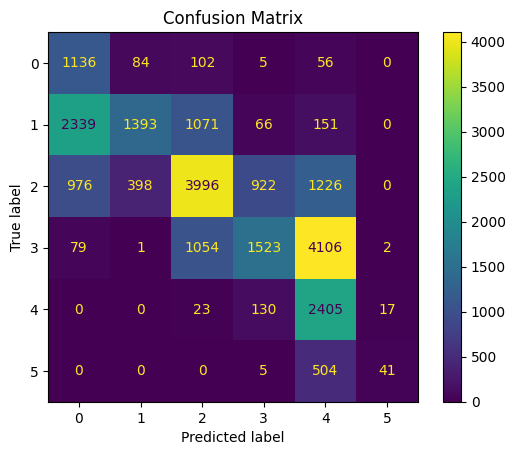

In [ ]:
cm = confusion_matrix(oof_df["score"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(config.num_classes)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Finish experiment

In [ ]:
wandb.finish()

CV/qwk_score,▁
eval/eval_epoch_f0,▁
eval/eval_epoch_f0_g0,▁█
eval/eval_epoch_f0_g1,▁█
eval/eval_epoch_f0_g2,▁█
eval/eval_epoch_f1,▁
eval/eval_epoch_f1_g0,▁█
eval/eval_epoch_f1_g1,▁█
eval/eval_epoch_f1_g2,▁█
eval/eval_epoch_f2,▁
eval/eval_epoch_f2_g0,▁█
